In [37]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 
%matplotlib inline

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [38]:
sns.set_context("talk", font_scale=1.4)

In [39]:
data = pd.read_csv('../data/prep/500.csv')
data.head()

,name,developer,rank,platform,release_date,publisher,na_sales,eu_sales,jp_sales,other_sales,...,meta_critic_count,meta_user_score,meta_user_count,meta_esrb,meta_genre,meta_multiplayer,meta_full_url,release_year,is_series,Matched_Name
0,Grand Theft Auto V,Rockstar North,4,PS3,2013-09-17,Rockstar Games,6370000,9850000,990000,3120000,...,50.0,8.3,4354,M,Modern,yes,https://www.metacritic.com/game/playstation-3/...,2013,yes,Grand Theft Auto V Grand Theft Auto IV Grand T...
1,Grand Theft Auto V,Rockstar North,6,PS4,2014-11-18,Rockstar Games,6060000,9710000,600000,3020000,...,66.0,8.3,4691,M,Action Adventure,yes,https://www.metacritic.com/game/playstation-4/...,2014,yes,Grand Theft Auto V Grand Theft Auto IV Grand T...
2,Grand Theft Auto: Vice City,Rockstar North,9,PS2,2002-10-28,Rockstar Games,8410000,5490000,470000,1780000,...,62.0,8.8,959,M,Action Adventure,no,https://www.metacritic.com/game/playstation-2/...,2002,yes,Grand Theft Auto: Vice City Grand Theft Auto: ...
3,Grand Theft Auto V,Rockstar North,10,X360,2013-09-17,Rockstar Games,9060000,5330000,60000,1420000,...,58.0,8.3,3817,M,Modern,yes,https://www.metacritic.com/game/xbox-360/grand...,2013,yes,Grand Theft Auto V Grand Theft Auto IV Grand T...
4,Grand Theft Auto IV,Rockstar North,13,X360,2008-04-29,Rockstar Games,6800000,3110000,140000,1040000,...,86.0,7.9,3234,M,Action Adventure,no,https://www.metacritic.com/game/xbox-360/grand...,2008,yes,Grand Theft Auto IV Grand Theft Auto V Grand T...


In [40]:
data['global_sales']=data['global_sales']/1000000

In [41]:
data['global_sales'].sample()

2438    0.57
Name: global_sales, dtype: float64

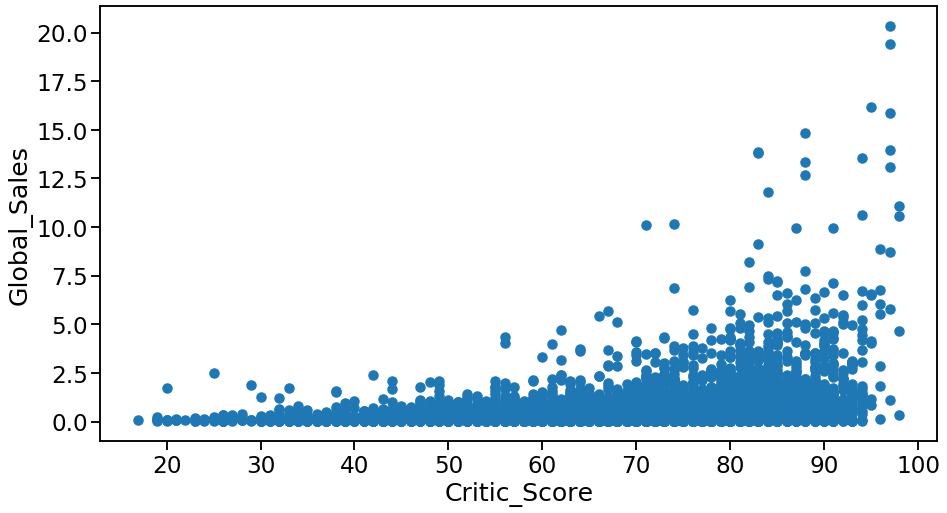

In [44]:
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(x = data['meta_critic_score'], y = data['global_sales'])
plt.ylabel('Global_Sales')
plt.xlabel('Critic_Score')
plt.show()


 mu = 0.57 and sigma = 1.09



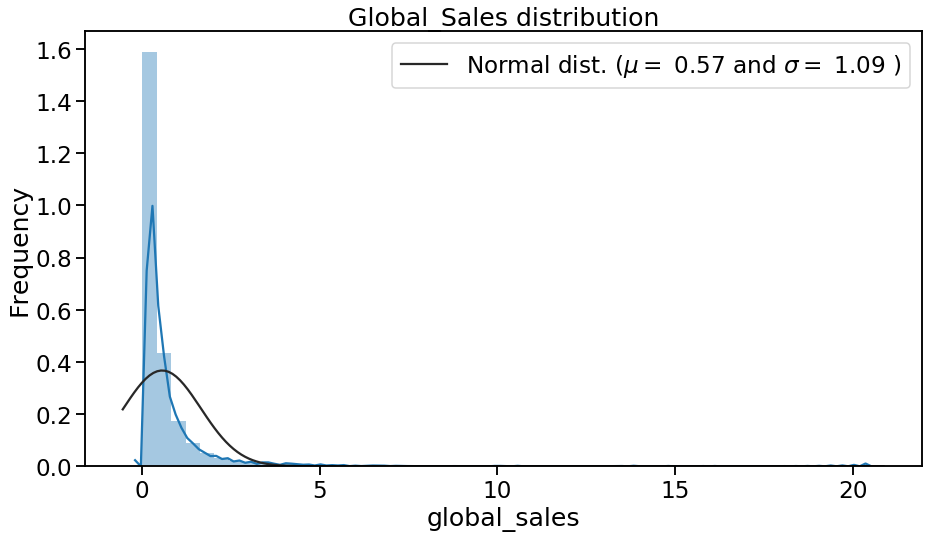

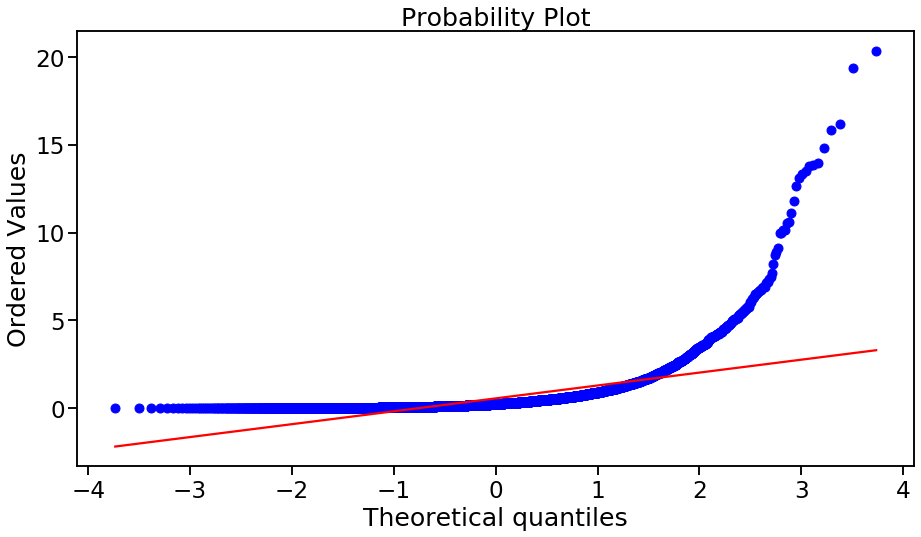

In [47]:
fig= plt.subplots(figsize=(15,8))
sns.distplot(data['global_sales'] , fit=norm);

(mu, sigma) = norm.fit(data['global_sales'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Global_Sales distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=(15,8))
res = stats.probplot(data['global_sales'], plot=plt)
plt.show()

As we can see, Global_Sales is nowhere normally distributed, which may be problematic for us down the line. However, as we have yet to further investigate the data, let's not do any transformations just yet. We'll look at doing a log-transformation down the line.

Before we move on to splitting the data into training and test sets, lets look at some feature correlations, to ensure that our independent variables don't suffer from autocorrelation, which may be problematic in some linear models such as liner regression if we want to look at feature importance through the intercepts. Let's do this by plotting a correlation heatmap with Seaborn.

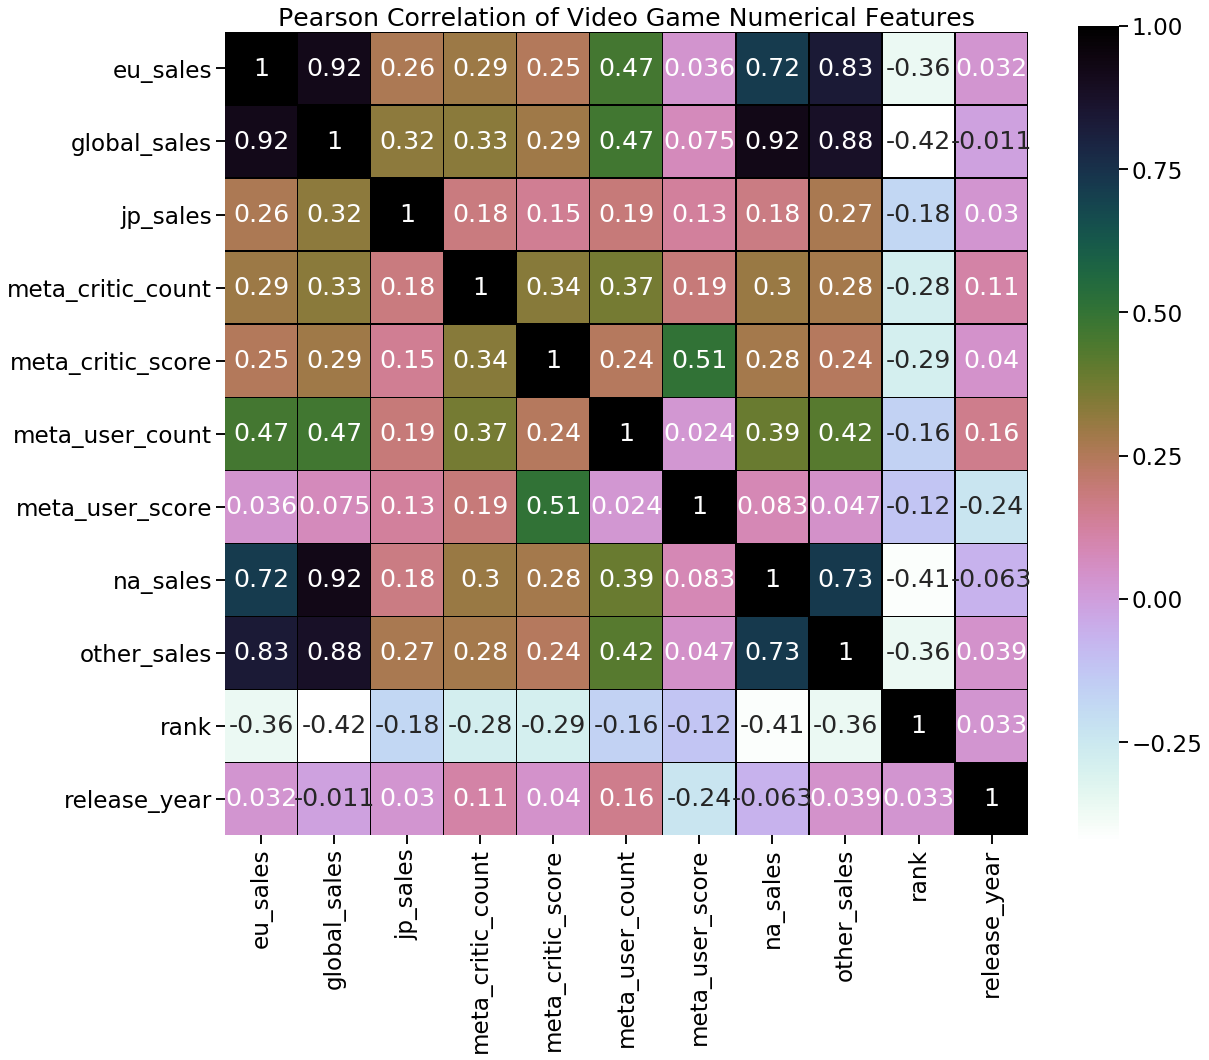

In [52]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in data.iteritems():
    if type(colvalue[2]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = data.columns.difference(str_list) 
# Create Dataframe containing only numerical features
data_num = data[num_list]
f, ax = plt.subplots(figsize=(18, 15))
plt.title('Pearson Correlation of Video Game Numerical Features')
# Draw the heatmap using seaborn
sns.heatmap(data_num.astype(float).corr(),linewidths=0.25,vmax=1.0, 
            square=True, cmap="cubehelix_r", linecolor='k', annot=True)

In terms of autocorrelation the prospective independent variables aren't too highly correlated with each other in the correlation heat map. Only sales numbers are highly correlated with each other. Therefore we can look at intercepts of regression models without too much worries if we wish to do so later on. Higher correlations between sales figures may speak to the global nature of the video game industry: a success in one continent usually means a success in another continent as well. This lends greater confidence to using just Global_Sales as the dependent variable.

However, here we have an issue. Publisher and Developer will cause a massive influx of features as there are so many unique values in the mix. At this point it seems best to drop these features entirely.

Instead, let's only create dummies for:
* Platform
* Genre
* Rating

In [53]:
print(data.shape) #pre-dummies shape
data = pd.get_dummies(data=data, columns=['platform', 'game_genre', 'meta_esrb','meta_multiplayer','is_series'])
print(data.shape) #post-dummies shape
data.head(1) #Check to verify that dummies are ok

(7374, 26)
(7374, 66)


,name,developer,rank,release_date,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,...,game_genre_Strategy,game_genre_Visual+Novel,meta_esrb_E,meta_esrb_E10+,meta_esrb_M,meta_esrb_T,meta_multiplayer_no,meta_multiplayer_yes,is_series_no,is_series_yes
0,Grand Theft Auto V,Rockstar North,4,2013-09-17,Rockstar Games,6370000,9850000,990000,3120000,20.32,...,0,0,0,0,1,0,0,1,0,1


Great! Let's drop the features we wish to discard for our models. These include:
* name
* publisher
* developer
* na_sales
* eu_sales
* jp_sales
* other_sales
* release_date
* game_url
* game_url_string
* meta_game_name
* meta_full_url
* meta_genre

In [54]:
data = data.drop(['name', 'publisher', 'developer', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales','release_date','game_url','game_url_string',
                  'meta_game_name','meta_full_url','meta_genre','Matched_Name','rank'], axis=1)

In [55]:
data.columns

Index(['global_sales', 'meta_critic_score', 'meta_critic_count',
       'meta_user_score', 'meta_user_count', 'release_year', 'platform_3DS',
       'platform_DC', 'platform_DS', 'platform_GBA', 'platform_GC',
       'platform_NS', 'platform_PC', 'platform_PS', 'platform_PS2',
       'platform_PS3', 'platform_PS4', 'platform_PSP', 'platform_PSV',
       'platform_Wii', 'platform_WiiU', 'platform_X360', 'platform_XB',
       'platform_XOne', 'game_genre_Action', 'game_genre_Action-Adventure',
       'game_genre_Adventure', 'game_genre_Board+Game', 'game_genre_Education',
       'game_genre_Fighting', 'game_genre_MMO', 'game_genre_Misc',
       'game_genre_Music', 'game_genre_Party', 'game_genre_Platform',
       'game_genre_Puzzle', 'game_genre_Racing', 'game_genre_Role-Playing',
       'game_genre_Shooter', 'game_genre_Simulation', 'game_genre_Sports',
       'game_genre_Strategy', 'game_genre_Visual+Novel', 'meta_esrb_E',
       'meta_esrb_E10+', 'meta_esrb_M', 'meta_esrb_T', 'meta_mu

Let's define X and Y and then split into training and test data

In [56]:

X = data[['meta_critic_score', 'meta_critic_count',
       'meta_user_score', 'meta_user_count', 'release_year',
       'platform_3DS', 'platform_DC', 'platform_DS', 'platform_GBA',
       'platform_GC', 'platform_NS', 'platform_PC', 'platform_PS',
       'platform_PS2', 'platform_PS3', 'platform_PS4', 'platform_PSP',
       'platform_PSV', 'platform_Wii', 'platform_WiiU', 'platform_X360',
       'platform_XB', 'platform_XOne', 'game_genre_Action',
       'game_genre_Action-Adventure', 'game_genre_Adventure',
       'game_genre_Board+Game', 'game_genre_Education', 'game_genre_Fighting',
       'game_genre_MMO', 'game_genre_Misc', 'game_genre_Music',
       'game_genre_Party', 'game_genre_Platform', 'game_genre_Puzzle',
       'game_genre_Racing', 'game_genre_Role-Playing', 'game_genre_Shooter',
       'game_genre_Simulation', 'game_genre_Sports', 'game_genre_Strategy',
       'game_genre_Visual+Novel', 'meta_esrb_E', 'meta_esrb_E10+',
       'meta_esrb_M', 'meta_esrb_T', 'meta_multiplayer_no',
       'meta_multiplayer_yes', 'is_series_no', 'is_series_yes']]

Y = pd.Series(data["global_sales"])

#Double checking the shape
print(X.shape)
print(Y.shape)

(7374, 50)
(7374,)


In [57]:
from sklearn.model_selection import train_test_split
basic_target = Y
basic_features = X
X_train, X_test, Y_train, Y_test = train_test_split(basic_features, basic_target, test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(5899, 50)
(1475, 50)
(5899,)
(1475,)


Now that we have the test split into training and test data we can still do some final scaling of the data before fitting the models.

As mentioned previously, lets do a log-transformation of the dependent variable in both the training and test data.

In [58]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
Y_train = np.log1p(Y_train)
Y_test = np.log1p(Y_test)


 mu = 0.35 and sigma = 0.38



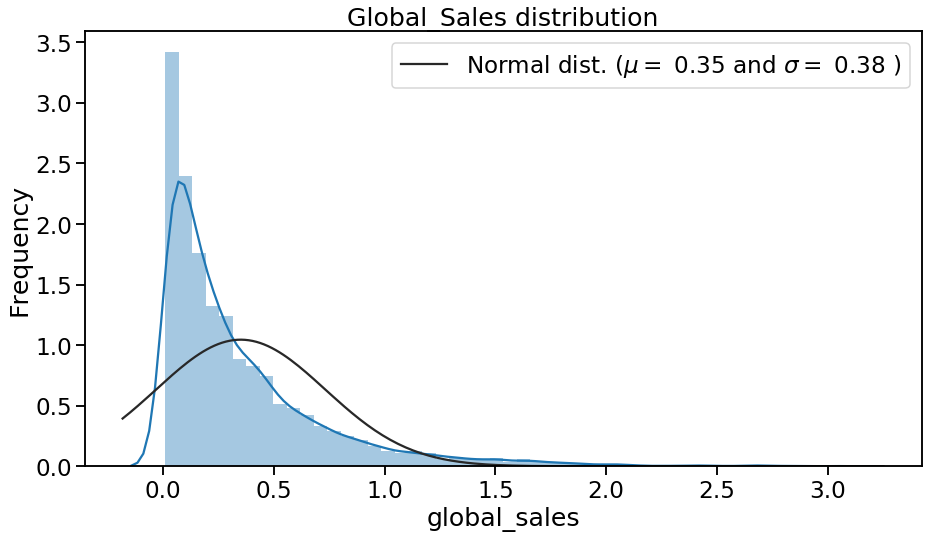

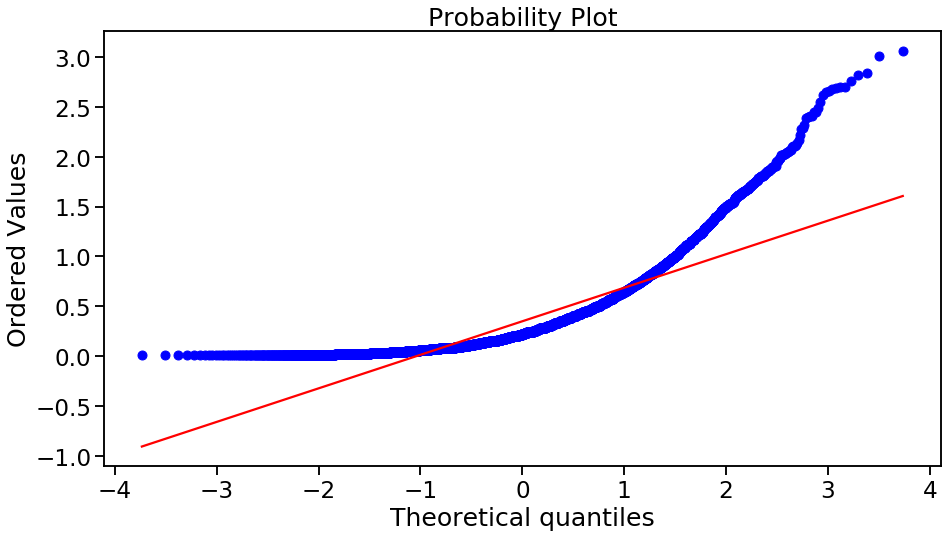

In [61]:
Y_log_transformed = np.log1p(data['global_sales']) #For comparison to earlier, here's the whole Y transformed
fig, ax = plt.subplots(figsize=(15,8))
sns.distplot(Y_log_transformed , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Y_log_transformed)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Global_Sales distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=(15,8))
res = stats.probplot(Y_log_transformed, plot=plt)
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

Now we are really close to the fun part. First however, we need to prepare our grids for grid search. For this, we need to decide, which models we will use. So let's try:

* Linear Regression
* Lasso
* Ridge Regression
* Support Vector Regressor
* Random Forest
* Gradient Boosting Regressor
* MLP Regressor a.k.a. a Neural Network

In [18]:
#No grid to define for vanilla linear regression
param_grid_lr = [
    {}
]

#Parameter grid for lasso
param_grid_lasso = [
    {'alpha': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'max_iter': [1000000, 100000, 10000, 1000]}
]

#Parameter grid for Ridge Regression
param_grid_rr = [
    {'alpha': [100, 10, 1, 0.1, 0.01, 0.001]}
]

#Parameter grid for Support Vector Regressor
param_grid_svr = [
    {'C': [0.01, 0.1, 1, 10], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
     'kernel': ['rbf']}
]

#Parameter grid for Random Forest
param_grid_rf = [
    {'n_estimators': [3, 10, 30, 50, 70], 'max_features': [2,4,6,8,10,12], 'max_depth': [2, 3, 5, 7, 9]}
]

#Parameter grid for Gradient Boosting Regressor
param_grid_gbr = [
    {'n_estimators': [200, 225, 250, 275], 'max_features': [6, 8, 10, 12], 'max_depth': [5, 7, 9]}
]

#Parameter grid for MLPRegressor. 
#Current set of hyperparameters are the result of grid search that took forever.
param_grid_mlpr = [
    {'hidden_layer_sizes': [(10,5)], 'solver': ['lbfgs'], 'batch_size': [200],
          'learning_rate': ['adaptive'], 'max_iter': [800], 'verbose': [True], 
     'nesterovs_momentum': [True], 'early_stopping': [True], 'validation_fraction': [0.12],
     'random_state': [100], 'alpha': [0.1], 'activation': ['logistic']}
]

Now that we have the parameter grids, let's implement the models one by one and see which does the best.

Let's use RMSE for scoring the models. The interpretation for RMSE, or Root Mean Squared Error, is more intuitive than that of the MSE as RMSE is an absolute measure of fit. It thus tells us our error in actual sales units. Also, to quote theanalysisfactor.com: "RMSE is a good measure of how accurately the model predicts the response, and is the most important criterion for fit if the main purpose of the model is prediction."

However, before interpreting the RMSE, we must also do an exp transformation on the RMSE scores to undo the log transformation and for the results to be more easily interpreted. Otherwise the RMSE will be in log(Global_Sales).

In conjunction with our grid search, let's use cross-validation with 5 folds.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

grid_search_lr = GridSearchCV(LinearRegression(), param_grid_lr, scoring='neg_mean_squared_error',  cv=5)
grid_search_lr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_lr.best_params_))
lr_best_cross_val_score = (np.sqrt(-grid_search_lr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(lr_best_cross_val_score)))
lr_score = np.sqrt(-grid_search_lr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(lr_score)))

Best parameters: {}
Best cross-validation score: 0.33
Test set score: 0.35


In [18]:
from sklearn.linear_model import Lasso

grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_lasso.best_params_))
lasso_best_cross_val_score = (np.sqrt(-grid_search_lasso.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(lasso_best_cross_val_score)))
lasso_score = np.sqrt(-grid_search_lasso.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(lasso_score)))

Best parameters: {'alpha': 0.0001, 'max_iter': 1000000}
Best cross-validation score: 0.33
Test set score: 0.35


In [19]:
from sklearn.linear_model import Ridge

grid_search_rr = GridSearchCV(Ridge(), param_grid_rr, cv=5, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_rr.best_params_))
rr_best_cross_val_score = (np.sqrt(-grid_search_rr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(rr_best_cross_val_score)))
rr_score = np.sqrt(-grid_search_rr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(rr_score)))

Best parameters: {'alpha': 1}
Best cross-validation score: 0.33
Test set score: 0.35


In [20]:
from sklearn.svm import SVR

grid_search_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_svr.best_params_))
svr_best_cross_val_score = (np.sqrt(-grid_search_svr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(svr_best_cross_val_score)))
svr_score = np.sqrt(-grid_search_svr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(svr_score)))

Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.37
Test set score: 0.39


In [21]:
from sklearn.ensemble import RandomForestRegressor

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_rf.best_params_))
rf_best_cross_val_score = (np.sqrt(-grid_search_rf.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(rf_best_cross_val_score)))
rf_score = np.sqrt(-grid_search_rf.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(rf_score)))

Best parameters: {'max_depth': 9, 'max_features': 12, 'n_estimators': 30}
Best cross-validation score: 0.30
Test set score: 0.32


In [26]:
from sklearn.ensemble import GradientBoostingRegressor

grid_search_gbr = GridSearchCV(GradientBoostingRegressor(), param_grid_gbr, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
grid_search_gbr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_gbr.best_params_))
gbr_best_cross_val_score = (np.sqrt(-grid_search_gbr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(gbr_best_cross_val_score)))
gbr_score = np.sqrt(-grid_search_gbr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(gbr_score)))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  6.9min finished


Best parameters: {'max_depth': 5, 'max_features': 10, 'n_estimators': 250}
Best cross-validation score: 0.26
Test set score: 0.28


In [63]:
from sklearn.neural_network import MLPRegressor

grid_search_mlpr = GridSearchCV(MLPRegressor(), param_grid_mlpr, cv=5, scoring='neg_mean_squared_error')
grid_search_mlpr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_mlpr.best_params_))
mlpr_best_cross_val_score = (np.sqrt(-grid_search_mlpr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(mlpr_best_cross_val_score)))
mlpr_score = np.sqrt(-grid_search_mlpr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(mlpr_score)))

Best parameters: {'activation': 'logistic', 'alpha': 0.1, 'batch_size': 200, 'early_stopping': True, 'hidden_layer_sizes': (10, 5), 'learning_rate': 'adaptive', 'max_iter': 800, 'nesterovs_momentum': True, 'random_state': 100, 'solver': 'lbfgs', 'validation_fraction': 0.12, 'verbose': True}
Best cross-validation score: 0.40
Test set score: 0.47


In [24]:
model_comparison = pd.DataFrame({"model": ['Linear Regression','Lasso', 'Ridge Regression', 'Support Vector Regressor',
'Random Forest', 'Gradient Boosting Regressor', 'MLP Regressor a.k.a. a Neural Network'],
                                 "tss": [np.expm1(lr_score), np.expm1(svr_score),np.expm1(rr_score), 
                                         np.expm1(svr_best_cross_val_score), np.expm1(rf_best_cross_val_score),np.expm1(gbr_best_cross_val_score), np.expm1(mlpr_best_cross_val_score)]})

model_comparison.to_csv('../data/analysis/model_comparison.csv')

In [62]:
model_comparison.sort_values("tss", ascending=False).plot(x="model", y="tss", kind="barh",color="lightskyblue", legend=False,figsize=(15,8))
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Test Set Score"); plt.xticks(size=14)
plt.title("Model Comparison on Test Set Score", size=20);

NameError: name 'model_comparison' is not defined

So the best model out of the seven we trained is the GBR! Let's therefore take a loot at the feature importances of the model as well to find out which features are the most important ones in explaining the results.

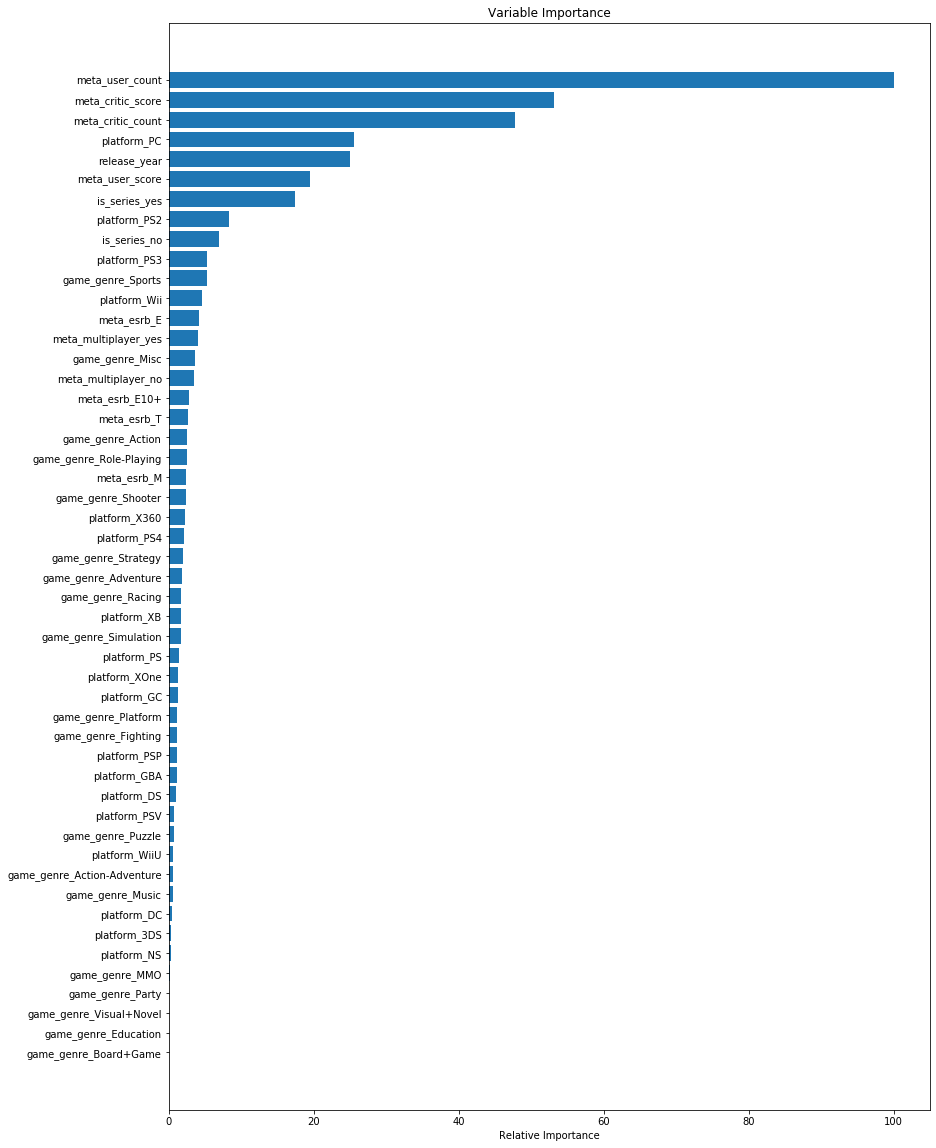

In [26]:
# Plot feature importance
feature_importance = grid_search_gbr.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(30,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns.values[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

An interesting finding is that the amount of users and the amount of critics rating a game on Metacritic is more important in explaining the results than the scores themselves. My initial hypothesis would have been the other way around. In this regard, it seems that it doesn't necessarily matter as much that a game has a single esteemed critic scoring the game a 100, but rather that the game has lots of critics scoring it potentially even at a lower level to drive those unit sales.

In terms of platforms, the only ones that maintained some relevant measure of explanatory power was whether the game was released on PC and whether it was released on Wii. There may be many interpretations here, so it is best to be wary in interpreting this. A game being released on Wii might speak towards explaining lower unit sales due to the platform not being as popular as it's counter parts PS3 and Xbox 360. In the case of a game being released on PC, it is difficult to say which way this explanatory power goes, as PC is such a large platform with all kinds of games being released on it.

In [59]:
labels=X_train.columns.values[sorted_idx].tolist()
%store feature_importance
%store labels

Stored 'feature_importance' (ndarray)
Stored 'labels' (list)


In [23]:
basic_final_pred=grid_search_gbr.predict(X_test)

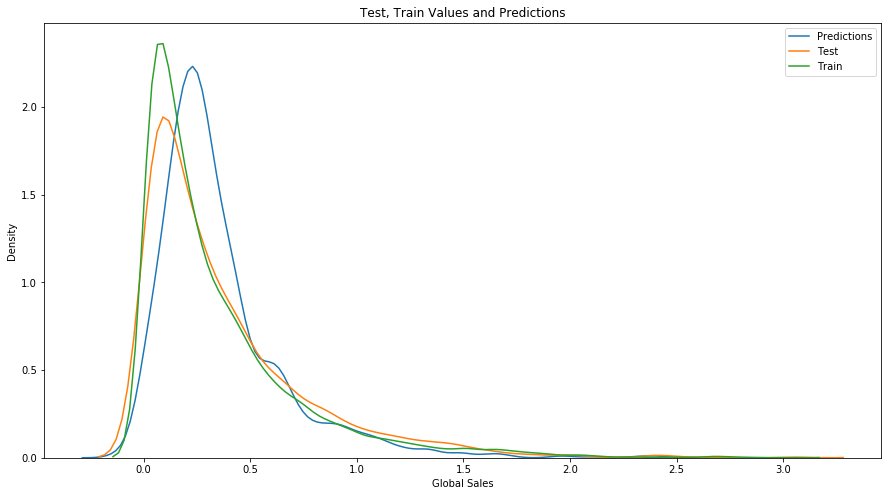

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
ax=sns.kdeplot(basic_final_pred, label = "Predictions")
ax=sns.kdeplot(Y_test, label = "Test")
ax=sns.kdeplot(Y_train, label = "Train")


plt.xlabel("Global Sales"); plt.ylabel("Density");
plt.title("Test, Train Values and Predictions");

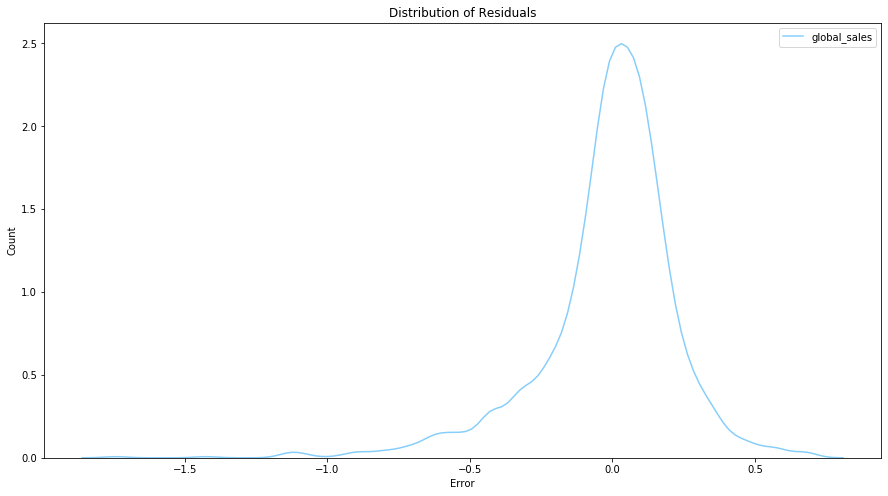

In [35]:
basic_residuals = basic_final_pred - Y_test

fig, ax = plt.subplots(figsize=(15,8))
sns.kdeplot(basic_residuals, color = "lightskyblue")
plt.xlabel("Error"); plt.ylabel("Count")
plt.title("Distribution of Residuals");